<a href="https://colab.research.google.com/github/C10udburst/ml-playground/blob/master/fcc_predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [ ]:
#@markdown <h3> Prevent Google Colab from disconnecting (optional)
import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button"); 
     btn.click() 
     }
   
   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect"); 
     btn.click() 
     }
  }
  
setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


In [ ]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [ ]:
if tf.test.gpu_device_name():
  device = "/GPU:0"
else:
  device = "/CPU:0"
print(device)

/CPU:0


In [ ]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2022-06-27 10:01:03--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0.001s  

2022-06-27 10:01:03 (63.0 MB/s) - ‘insurance.csv’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [ ]:
dataset['sex'] = pd.factorize(dataset['sex'])[0]
dataset['smoker'] = pd.factorize(dataset['smoker'])[0]
dataset['region'] = pd.factorize(dataset['region'])[0]
dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,1,31.0,3,1,2,10600.55
1334,18,0,31.9,0,1,3,2205.98
1335,18,0,36.9,0,1,1,1629.83
1336,21,0,25.8,0,1,0,2007.95
1337,61,0,29.1,0,0,2,29141.36


In [ ]:
target = dataset.pop('expenses').reset_index()
target.tail()

,index,expenses
1333,1333,10600.55
1334,1334,2205.98
1335,1335,1629.83
1336,1336,2007.95
1337,1337,29141.36


In [ ]:
test_dataset_size = int(len(dataset) * 0.2)
train_dataset_size = len(dataset) - test_dataset_size

test_dataset_size, train_dataset_size

(267, 1071)

In [ ]:
dataset.head().to_numpy()

array([[19. ,  0. , 27.9,  0. ,  0. ,  0. ],
       [18. ,  1. , 33.8,  1. ,  1. ,  1. ],
       [28. ,  1. , 33. ,  3. ,  1. ,  1. ],
       [33. ,  1. , 22.7,  0. ,  1. ,  2. ],
       [32. ,  1. , 28.9,  0. ,  1. ,  2. ]])

In [ ]:
with tf.device(device):
  train_ds = tf.data.Dataset.from_tensor_slices(
            (
              np.expand_dims(dataset.head(train_dataset_size).to_numpy(), 1),
              np.expand_dims(target.head(train_dataset_size)['expenses'].to_numpy(), 1)
            ))

  test_dataset = dataset.tail(test_dataset_size).to_numpy()
  test_labels = target.tail(test_dataset_size)['expenses']

train_ds, test_dataset, test_labels

(<TensorSliceDataset element_spec=(TensorSpec(shape=(1, 6), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.float64, name=None))>,
 array([[63. ,  1. , 31.4,  0. ,  1. ,  3. ],
        [21. ,  1. , 31.3,  0. ,  1. ,  2. ],
        [54. ,  0. , 28.9,  2. ,  1. ,  3. ],
        ...,
        [18. ,  0. , 36.9,  0. ,  1. ,  1. ],
        [21. ,  0. , 25.8,  0. ,  1. ,  0. ],
        [61. ,  0. , 29.1,  0. ,  0. ,  2. ]]),
 1071    13974.46
 1072     1909.53
 1073    12096.65
 1074    13204.29
 1075     4562.84
           ...   
 1333    10600.55
 1334     2205.98
 1335     1629.83
 1336     2007.95
 1337    29141.36
 Name: expenses, Length: 267, dtype: float64)

In [ ]:
dataset.shape

(1338, 6)

In [ ]:
with tf.device(device):
  model = keras.Sequential()
  model.add(keras.Input(shape=(6,)))
  model.add(keras.layers.Normalization(axis=-1))
  model.add(layers.Dense(128, activation='relu'))
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dense(1))

model.build(dataset.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13,390
Trainable params: 13,377
Non-trainable params: 13
___________________________________________________

In [ ]:
with tf.device(device):
  model.compile(optimizer='rmsprop', loss='mae', metrics=['mae','mse'])


In [ ]:
class StopCallback(keras.callbacks.Callback):
  def __init__(self, monitor, max_val, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.monitor = monitor
    self.max_val = max_val

  def on_epoch_end(self, epoch, logs={}):
    if logs[self.monitor] <= self.max_val:
      print(flush=True)
      print(f"Reached {self.monitor} of {logs[self.monitor]}. Stopping!", flush=True)
      self.model.stop_training = True

In [ ]:
with tf.device(device):
  history = model.fit(
      train_ds,
      epochs=110,
      batch_size=1<<16,
      use_multiprocessing=True,
      workers=4,
      verbose=2,
      callbacks=[
        StopCallback('mae', 3300),
        keras.callbacks.EarlyStopping(monitor='loss', patience=25, restore_best_weights=True)
      ])

Epoch 1/110
1071/1071 - 2s - loss: 7842.0625 - mae: 7842.0625 - mse: 173727168.0000 - 2s/epoch - 2ms/step
Epoch 2/110
1071/1071 - 2s - loss: 6900.2114 - mae: 6900.2114 - mse: 156433280.0000 - 2s/epoch - 2ms/step
Epoch 3/110
1071/1071 - 2s - loss: 6527.4844 - mae: 6527.4844 - mse: 158000256.0000 - 2s/epoch - 2ms/step
Epoch 4/110
1071/1071 - 2s - loss: 6388.1167 - mae: 6388.1167 - mse: 155575184.0000 - 2s/epoch - 2ms/step
Epoch 5/110
1071/1071 - 2s - loss: 6256.7397 - mae: 6256.7397 - mse: 151981904.0000 - 2s/epoch - 2ms/step
Epoch 6/110
1071/1071 - 2s - loss: 6087.0239 - mae: 6087.0239 - mse: 146658288.0000 - 2s/epoch - 2ms/step
Epoch 7/110
1071/1071 - 3s - loss: 5872.5991 - mae: 5872.5991 - mse: 138459024.0000 - 3s/epoch - 2ms/step
Epoch 8/110
1071/1071 - 2s - loss: 5617.5264 - mae: 5617.5264 - mse: 127317912.0000 - 2s/epoch - 2ms/step
Epoch 9/110
1071/1071 - 2s - loss: 5281.4360 - mae: 5281.4360 - mse: 111055992.0000 - 2s/epoch - 2ms/step
Epoch 10/110
1071/1071 - 2s - loss: 4796.1548 

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

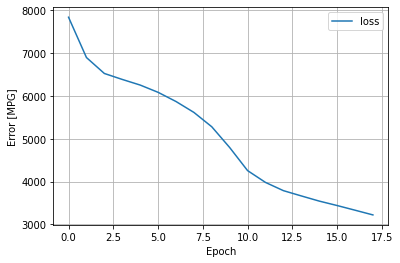

In [ ]:
plot_loss(history)

In [ ]:
np.amin(history.history['mae'])

3220.642578125

9/9 - 0s - loss: 3297.6826 - mae: 3297.6826 - mse: 36999772.0000 - 263ms/epoch - 29ms/step
Testing set Mean Abs Error: 3297.68 expenses
You passed the challenge. Great job!


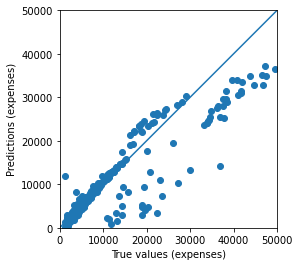

In [ ]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
